In [4]:
import pandas as pd
import numpy as np

from demoparser2 import DemoParser

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from kneed import KneeLocator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

from scipy.stats import chi2_contingency



In [5]:

# MAP_NAME = strings of maps (de_ancient, de_mirage, de_inferno, de_overpass, de_nuke, de_vertigo)
# side = 'T' or 'CT' (team name)
def smoke_df(MAP_NAME, side):
    
    df = pd.read_csv("IEM_DALLAS_2025_SMOKES.csv")  
    main_df = df.loc[df['map_name'] == MAP_NAME]
    t_smokes_df = main_df.loc[main_df['team_name'] == side]

    return t_smokes_df



In [6]:
# How to use: this function takes coordinates from df input and runs DBSCAN clustering on them.
# It returns the df with a new column 'cluster' that contains the cluster labels.
def smoke_clustering_dbscan(df):
    # Extract coordinates from the DataFrame
    coords = df[['x', 'y', 'z']].values

    # Run DBSCAN
    smoke_radius = 150
    dimensions = 3 # 3D coordinates (x, y, z)
    convention = dimensions * 2 # standard convention for min_samples in DBSCAN
    temp = DBSCAN(eps=smoke_radius, min_samples=convention).fit(coords)
    
    # Assign labels to the DataFrame
    df['cluster'] = temp.labels_
    return df




In [7]:
def plot_smoke_clusters_in_2d(main_df):
    plt.figure(figsize=(10, 8))
    
    for label in sorted(main_df['cluster'].unique()):
        cluster_df = main_df[main_df['cluster'] == label]
        color = 'k' if label == -1 else None
        
        # Plot points
        plt.scatter(cluster_df['x'], cluster_df['y'],
                    label=f'Cluster {label}' if label != -1 else 'Noise',
                    s=40, alpha=0.7, edgecolors='w', c=color)
        
        # Add label at centroid for each cluster (except noise)
        if label != -1:
            cx = cluster_df['x'].mean() - 100
            cy = cluster_df['y'].mean() - 100
            plt.text(cx, cy, str(label), fontsize=12, weight='bold',
                     ha='center', va='center', color='black',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    plt.xlabel("X (map units)")
    plt.ylabel("Y (map units)")
    plt.title("Top-Down 2D View of 3D Smoke Clusters")
    plt.grid(True)
    plt.axis("equal")
    plt.show()

In [8]:

# to be used for inference test later (WIP)
def get_round_wins_df(map_name, side):

    main_stats_df = pd.read_csv("demos.csv")
    if side == 'T':
        main_stats_df['is_T'] = (main_stats_df['round_ct_team'] != main_stats_df['team_name'])
        main_stats_df = main_stats_df[main_stats_df['is_T']]
    else:
        main_stats_df['is_CT'] = (main_stats_df['round_ct_team'] == main_stats_df['team_name'])
        main_stats_df = main_stats_df[main_stats_df['is_CT']]


    main_stats_df['is_win'] = (main_stats_df['round_result'] == 'CT') & (main_stats_df['round_ct_team'] == main_stats_df['team_name']) | (main_stats_df['round_result'] == 'T') & (main_stats_df['round_ct_team'] != main_stats_df['team_name'])
    round_wins = main_stats_df.drop_duplicates(subset=['team_name', 'round_number', 'is_win'])

    round_wins = round_wins[['team_name', 'round_id','round_number', 'is_win', 'map_name']]

    wins_df = round_wins[round_wins['map_name'] == map_name]
    
  
    return wins_df





In [75]:
# Create baskets for association rule mining
# Each basket contains clusters of smokes thrown in a round, with the win/loss as consequence.
def create_baskets(df):
    filtered_df = df[df['cluster'] != -1].copy()
    filtered_df = filtered_df.sort_values(by=['mapid', 'matchid', 'round_number', 'round_tick'])

    baskets = []

    # We group this because we want to create a basket for each smoke throwm in a round
    for _, round_df in filtered_df.groupby(['mapid', 'matchid', 'round_number']):
        round_df = round_df.reset_index(drop=True)

        for i in range(len(round_df)):
            base_tick = round_df.loc[i, 'round_tick']
            win_label = 'win' if round_df.loc[i, 'is_win'] else 'loss'

            # Get smokes within 640 ticks from this throw, 640 ticks is 10 seconds in CS2
            temp = (round_df['round_tick'] >= base_tick) & (round_df['round_tick'] <= base_tick + 640)
            clusters_in_window = round_df.loc[temp, 'cluster'].unique().tolist()

            if len(clusters_in_window) > 0:
                basket = [str(c) for c in clusters_in_window] + [win_label]

                baskets.append(basket)
    print(baskets)
    return baskets

In [10]:
def association_rule_mining(baskets):
    # Special thanks to https://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/ and 
    # https://www.geeksforgeeks.org/machine-learning/implementing-apriori-algorithm-in-python/ for the guide on ARM
    te = TransactionEncoder()
    te_ary = te.fit(baskets).transform(baskets)
    basket_df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = apriori(basket_df, min_support=0.05, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

    # Filtering for rules where 'win' is the consequence
    win_rules = rules[rules['consequents'] == {'win'}]
    
    # Display the top rules
    print(win_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
    return win_rules
    

In [12]:
MAP_NAME = 'de_ancient' # You can change this to any map name you want to analyze
SIDE = 'T'  # 'T' or 'CT'

[['0', 'loss'], ['1', '2', 'win'], ['2', 'win'], ['1', '2', 'win'], ['2', 'win'], ['2', '3', 'win'], ['3', 'win'], ['1', '2', 'win'], ['2', 'win'], ['4', 'win'], ['4', 'win'], ['1', 'loss'], ['2', 'loss'], ['4', 'loss'], ['1', '5', 'win'], ['5', 'win'], ['3', 'win'], ['1', '5', 'loss'], ['5', 'loss'], ['0', '3', 'loss'], ['3', 'loss'], ['1', '5', 'win'], ['5', 'win'], ['3', 'win'], ['6', 'win'], ['1', 'win'], ['5', '3', 'win'], ['3', 'win'], ['3', 'win'], ['1', '5', 'win'], ['5', 'win'], ['1', '5', '6', 'win'], ['5', '6', 'win'], ['6', 'win'], ['1', 'win'], ['1', 'win'], ['5', '6', 'loss'], ['6', 'loss'], ['3', 'loss'], ['3', 'loss'], ['6', 'loss'], ['1', 'loss'], ['0', 'loss'], ['1', 'win'], ['5', 'win'], ['1', '5', 'win'], ['5', 'win'], ['1', 'win'], ['3', 'win'], ['3', 'win'], ['1', 'win'], ['2', 'win'], ['4', '0', 'win'], ['0', 'win'], ['1', '2', 'win'], ['2', 'win'], ['0', 'win'], ['1', 'win'], ['2', 'win'], ['4', '0', 'win'], ['0', 'win'], ['1', '2', 'win'], ['2', 'win'], ['0', '

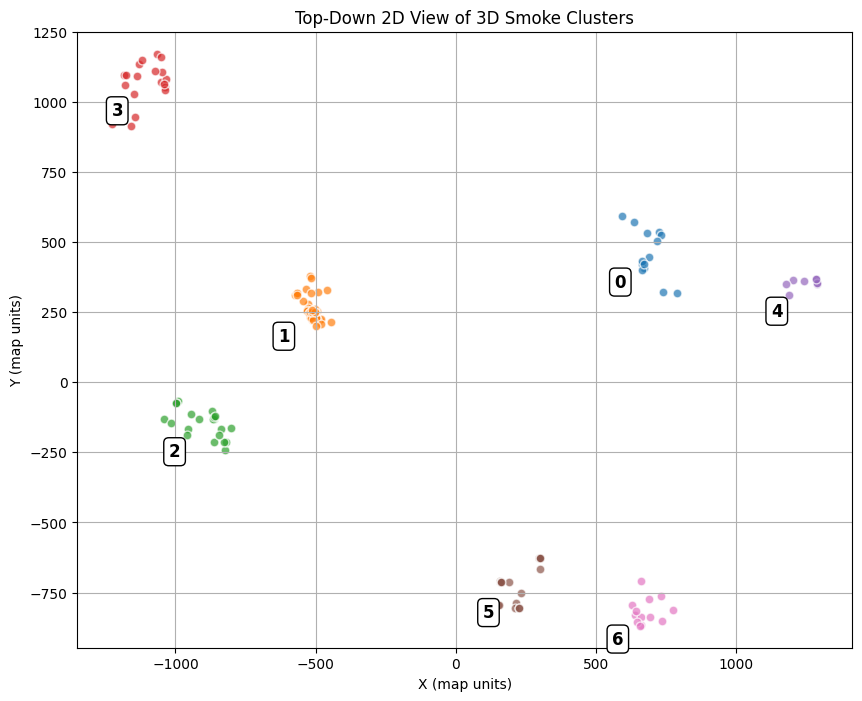

[['0', 'loss'], ['1', '2', 'win'], ['2', 'win'], ['1', '2', 'win'], ['2', 'win'], ['2', '3', 'win'], ['3', 'win'], ['1', '2', 'win'], ['2', 'win'], ['4', 'win'], ['4', 'win'], ['1', 'loss'], ['2', 'loss'], ['4', 'loss'], ['1', '5', 'win'], ['5', 'win'], ['3', 'win'], ['1', '5', 'loss'], ['5', 'loss'], ['0', '3', 'loss'], ['3', 'loss'], ['1', '5', 'win'], ['5', 'win'], ['3', 'win'], ['6', 'win'], ['1', 'win'], ['5', '3', 'win'], ['3', 'win'], ['3', 'win'], ['1', '5', 'win'], ['5', 'win'], ['1', '5', '6', 'win'], ['5', '6', 'win'], ['6', 'win'], ['1', 'win'], ['1', 'win'], ['5', '6', 'loss'], ['6', 'loss'], ['3', 'loss'], ['3', 'loss'], ['6', 'loss'], ['1', 'loss'], ['0', 'loss'], ['1', 'win'], ['5', 'win'], ['1', '5', 'win'], ['5', 'win'], ['1', 'win'], ['3', 'win'], ['3', 'win'], ['1', 'win'], ['2', 'win'], ['4', '0', 'win'], ['0', 'win'], ['1', '2', 'win'], ['2', 'win'], ['0', 'win'], ['1', 'win'], ['2', 'win'], ['4', '0', 'win'], ['0', 'win'], ['1', '2', 'win'], ['2', 'win'], ['0', '

In [79]:


main_df = smoke_df(MAP_NAME, SIDE)

main_df = smoke_clustering_dbscan(main_df)
baskets = create_baskets(main_df)
main_df = main_df[main_df['cluster'] != -1]  # Filter out noise clusters
plot_smoke_clusters_in_2d(main_df)

baskets = create_baskets(main_df)
win_rules = association_rule_mining(baskets)




In [55]:
# This creates the count columns for clusters which will be used for the chi-squared test
def create_binary_columns_for_clusters(main_df, win_rules, MAP_NAME, SIDE):
    # Add columns for each cluster
    temp_df = pd.crosstab(main_df['round_id'], main_df['cluster'])
    main_df = pd.merge(main_df, temp_df, on='round_id', how='inner')

    all_clusters = sorted(main_df['cluster'].unique())

    # We drop useless columns and duplicates
    for c in all_clusters:
        main_df.rename(columns={c: f'cluster_{c}'}, inplace=True)
        main_df.drop_duplicates(subset=['round_id', f'cluster_{c}'], inplace=True)
        main_df.drop(columns=['tick', 'user_name'])  # Ensure no duplicates in columns
        main_df.loc[main_df[f'cluster_{c}'] > 0, f'cluster_{c}'] = 1 # This is to ensure that we have binary columns for clusters not counts


    return main_df

In [72]:
def get_chi_squared_test(round_df, all_clusters):  
    # We do a chi-squared test for each cluster
    for c in all_clusters:
        contingency = pd.crosstab(round_df[f'cluster_{c}'], round_df['is_win']) # This makes it so that we can see the frequency of each cluster in winning and losing rounds
        chi2, p, _, _ = chi2_contingency(contingency, correction=False)
        print(f"Cluster {c} → p = {p:.9f}, X^2={chi2:.9f}")
 
       




is_win,False,True
cluster,,
1,14,29


In [77]:
for_chi_squared_test = create_binary_columns_for_clusters(main_df, win_rules, MAP_NAME, SIDE)
#for_chi_squared_test
c = 1
contingency = pd.crosstab(for_chi_squared_test[f'cluster_{c}'], for_chi_squared_test['is_win'])
print(contingency)

get_chi_squared_test(for_chi_squared_test, sorted(main_df['cluster'].unique()))

is_win     False  True 
cluster_1              
0              5      0
1             12     26
Cluster 0 → p = 0.756871055, X^2=0.095847358
Cluster 1 → p = 0.003264784, X^2=8.653250774
Cluster 2 → p = 0.114684648, X^2=2.488449631
Cluster 3 → p = 0.663424295, X^2=0.189390607
Cluster 4 → p = 0.516732298, X^2=0.420410472
Cluster 5 → p = 0.941394843, X^2=0.005404726
Cluster 6 → p = 0.558967241, X^2=0.341495533


In [386]:
# PLEASE READ THRU THE DOCS AND CODE, message me if there's errors - nTony
